In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

Let's test the VAR model with monthly data.

Import the data (I'll first try with monthly data).

In [30]:
dvar = pd.read_csv("../Data/monthly_data.csv")

In [31]:
dvar = dvar.dropna()
dvar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 1 to 94
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   datetime                 94 non-null     object 
 1   suction_tension (20cm)   94 non-null     float64
 2   suction_tension (40cm)   94 non-null     float64
 3   suction_tension (70cm)   94 non-null     float64
 4   water_temperature        94 non-null     float64
 5   barometric_pressure_qfe  94 non-null     float64
 6   dew_point                94 non-null     float64
 7   water_level              94 non-null     float64
 8   inflow_linth (m3/s)      94 non-null     float64
 9   outflow_limmat (m3/s)    94 non-null     float64
 10  precipitation (mm)       94 non-null     float64
 11  Evapotranspiration (mm)  94 non-null     float64
 12  change_rate              94 non-null     float64
dtypes: float64(12), object(1)
memory usage: 10.3+ KB


In [32]:
# convert DateTime column into datetime format
dvar["datetime"] = pd.to_datetime(dvar['datetime'])
# set DateTime as index
dvar.set_index("datetime", inplace=True)
dvar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94 entries, 2012-02-29 to 2019-11-30
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   94 non-null     float64
 1   suction_tension (40cm)   94 non-null     float64
 2   suction_tension (70cm)   94 non-null     float64
 3   water_temperature        94 non-null     float64
 4   barometric_pressure_qfe  94 non-null     float64
 5   dew_point                94 non-null     float64
 6   water_level              94 non-null     float64
 7   inflow_linth (m3/s)      94 non-null     float64
 8   outflow_limmat (m3/s)    94 non-null     float64
 9   precipitation (mm)       94 non-null     float64
 10  Evapotranspiration (mm)  94 non-null     float64
 11  change_rate              94 non-null     float64
dtypes: float64(12)
memory usage: 9.5 KB


In [35]:
dvar = dvar.drop(['suction_tension (20cm)', 'suction_tension (40cm)', 'suction_tension (70cm)', 'barometric_pressure_qfe', 'precipitation (mm)', 'change_rate', 'Evapotranspiration (mm)'], axis=1)

Visualize the Time Series

In [36]:
dvar

,water_temperature,dew_point,water_level,inflow_linth (m3/s),outflow_limmat (m3/s)
datetime,,,,,
2012-02-29,3.763932,-5.502229,405.714322,32.760742,71.399478
2012-03-31,6.225431,2.637923,405.729378,37.625103,74.477262
2012-04-30,8.165806,4.671373,405.782916,53.851635,89.626478
2012-05-31,13.520385,9.016868,405.838784,103.872095,138.309852
2012-06-30,19.031148,13.509106,406.105133,128.218092,198.238391
...,...,...,...,...,...
2019-07-31,24.084946,14.464124,406.020067,71.571097,95.779511
2019-08-31,23.290390,15.115188,406.072119,71.688215,111.881487
2019-09-30,20.211435,11.901181,406.036799,50.994090,85.795989


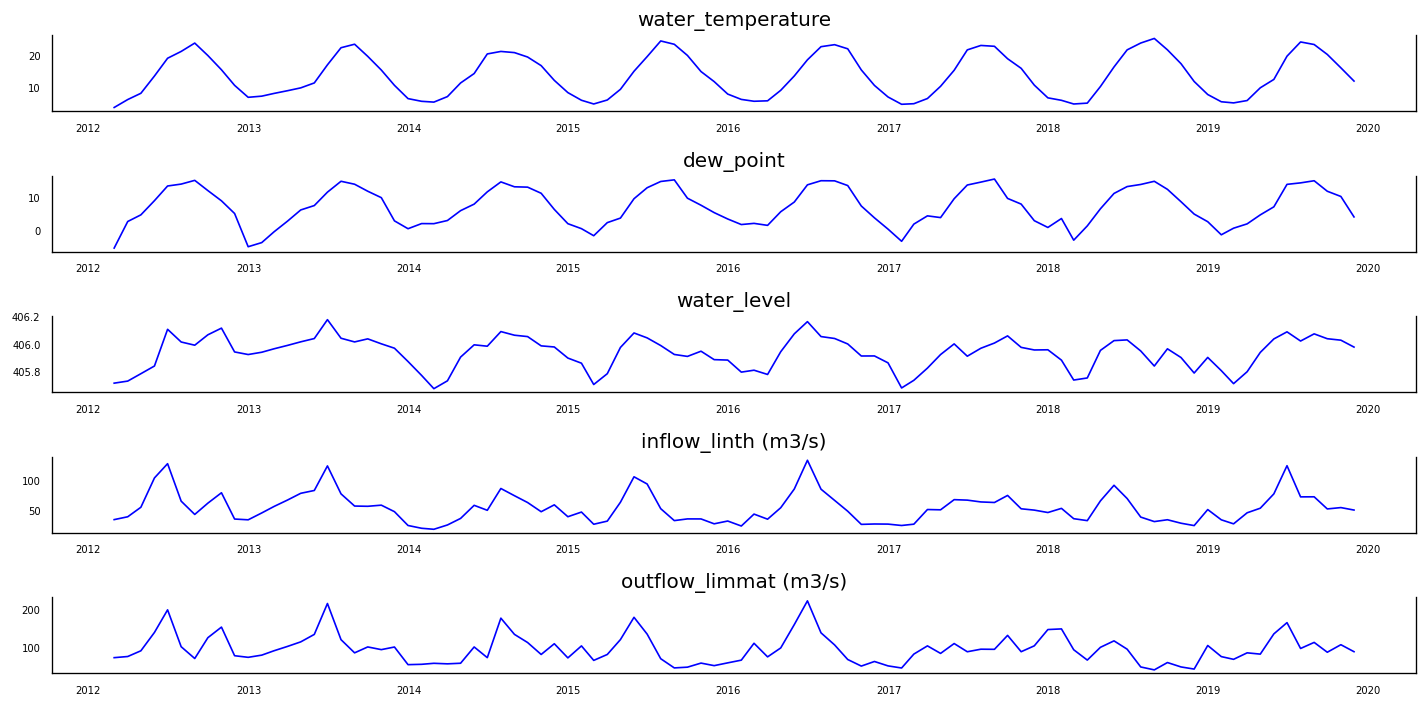

In [37]:
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = dvar[dvar.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(dvar.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

As shown in the figure above, there is quite some seasonality.

Check for causality (Granger).

In [38]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    
    #The rows are the response variable, columns are predictors. The values in the table are the P-Values. P-Values lesser than the significance level (0.05), implies the Null Hypothesis that the coefficients of the corresponding past values is zero, that is, the X does not cause Y can be rejected.

    dvar = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dvar.columns:
        for r in dvar.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dvar.loc[r, c] = min_p_value
    dvar.columns = [var + '_x' for var in variables]
    dvar.index = [var + '_y' for var in variables]
    return dvar

grangers_causation_matrix(dvar, variables = dvar.columns) 

,water_temperature_x,dew_point_x,water_level_x,inflow_linth (m3/s)_x,outflow_limmat (m3/s)_x
water_temperature_y,1.0000,0.000,0.0002,0.0000,0.0000
dew_point_y,0.0000,1.000,0.0088,0.0000,0.0034
water_level_y,0.0000,0.000,1.0000,0.0024,0.0006
inflow_linth (m3/s)_y,0.0000,0.000,0.0008,1.0000,0.0070
outflow_limmat (m3/s)_y,0.0004,0.001,0.0196,0.0538,1.0000


The row are the Response (Y) and the columns are the predictor series (X).

Cointegration test.

In [39]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(dvar, alpha=0.05): 
    out = coint_johansen(dvar,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(dvar.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(dvar)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
water_temperature ::  134.15    > 60.0627   =>   True
dew_point ::  62.89     > 40.1749   =>   True
water_level ::  29.74     > 24.2761   =>   True
inflow_linth (m3/s) ::  9.32      > 12.3212   =>   False
outflow_limmat (m3/s) ::  0.26      > 4.1296    =>   False


Order of integration(d) is nothing but the number of differencing required to make a non-stationary time series stationary.

Now, when you have two or more time series, and there exists a linear combination of them that has an order of integration (d) less than that of the individual series, then the collection of series is said to be cointegrated.

Split the data

In [40]:
nobs = 24
dvar_train, dvar_test = dvar[0:-nobs], dvar[-nobs:]

print(dvar_train.shape)  
print(dvar_test.shape)

(70, 5)
(24, 5)


Stationarity.
For the VAR Model only stationary time series can be used. In order to verify it, we are going to use the ADF test.

In [41]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [42]:
for name, column in dvar_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "water_temperature" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.615
 No. Lags Chosen       = 8
 Critical value 1%     = -3.542
 Critical value 5%     = -2.91
 Critical value 10%    = -2.593
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "dew_point" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.8845
 No. Lags Chosen       = 6
 Critical value 1%     = -3.539
 Critical value 5%     = -2.909
 Critical value 10%    = -2.592
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "water_level" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signif

C:\Users\lunam\AppData\Local\Temp\ipykernel_19196\1179845333.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in dvar_train.iteritems():


All except water level are stationary. We need to difference the variables and then check the ADF one more time.

Selection of the p order for the VAR.

In [56]:
model = VAR(dvar_train)
for i in [1,2,3,4,5,6,7,8,9, 10, 11, 12, 13, 14, 15]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

c:\Users\lunam\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Lag Order = 1
AIC :  7.407426163975913
BIC :  8.378776818148634
FPE :  1651.81156417976
HQIC:  7.792793404846546 

Lag Order = 2
AIC :  6.459034701700229
BIC :  8.254224757357376
FPE :  647.663043195356
HQIC:  7.170343981217675 

Lag Order = 3
AIC :  6.429317647579564
BIC :  9.06178644685236
FPE :  649.5844309641329
HQIC:  7.470992135737635 

Lag Order = 4
AIC :  5.836262884831584
BIC :  9.319804519873623
FPE :  384.01163339746086
HQIC:  7.212775753229512 

Lag Order = 5
AIC :  5.977328304490287
BIC :  10.32610284428156
FPE :  499.60491018030075
HQIC:  7.693198647812778 

Lag Order = 6
AIC :  5.81089952409404
BIC :  11.039444491605744
FPE :  520.0870361413324
HQIC:  7.870687494099994 

Lag Order = 7
AIC :  5.501922821198551
BIC :  11.625164896602932
FPE :  535.9559782482854
HQIC:  7.910223858962318 

Lag Order = 8
AIC :  3.9361922605709
BIC :  10.969459178865154
FPE :  195.25800513600737
HQIC:  6.697630295805406 

Lag Order = 9
AIC :  1.7776428513110627
BIC :  9.736675453931744
FPE :  

LinAlgError: 4-th leading minor of the array is not positive definite

Let's try lag 3.

Train the model with the lag 3.

In [57]:
model_fitted = model.fit(10)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 28, Nov, 2022
Time:                     14:24:47
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    7.28501
Nobs:                     60.0000    HQIC:                   1.86570
Log likelihood:          -122.203    FPE:                    11.5371
AIC:                     -1.61596    Det(Omega_mle):        0.532400
--------------------------------------------------------------------
Results for equation water_temperature
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                          9886.935629      5128.474242            1.928           0.054
L1.water_temperature             -0.131922         0.333630           -0.395           0.693


Residuals with Durbin Watson Statistic

In [58]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(dvar.columns, out):
    print(col, ':', round(val, 2))

water_temperature : 2.18
dew_point : 1.63
water_level : 2.1
inflow_linth (m3/s) : 2.08
outflow_limmat (m3/s) : 1.91


CHECK THE MEANING

Forecasting

In [59]:
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input = dvar_train.values[-lag_order:]
forecast_input

10


array([[  4.93639385,   1.84155754, 405.73511161,  25.00345089,
         80.91566815],
       [  6.54096678,   4.3652946 , 405.82361064,  49.98238441,
        102.66312295],
       [ 10.33565741,   3.83439352, 405.9219537 ,  49.49614861,
         82.71230833],
       [ 15.30334101,   9.61227471, 405.99926901,  66.82750499,
        108.84768875],
       [ 21.62543056,  13.81040741, 405.90993657,  66.01899028,
         87.09938611],
       [ 22.9996371 ,  14.70146505, 405.96766039,  62.92683602,
         93.85670833],
       [ 22.73757149,  15.63542056, 406.0054694 ,  61.98367045,
         93.52624954],
       [ 18.88561907,   9.70405331, 406.05741054,  74.02580814,
        130.51692877],
       [ 15.90362224,   7.96859351, 405.9740634 ,  51.23605577,
         87.18781411],
       [ 10.69653577,   2.88392139, 405.95519349,  48.97624635,
        102.78598797]])

In [60]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
dvar_forecast = pd.DataFrame(fc, index=dvar.index[-nobs:], columns=dvar.columns)
dvar_forecast

,water_temperature,dew_point,water_level,inflow_linth (m3/s),outflow_limmat (m3/s)
datetime,,,,,
2017-12-31,7.647291,1.167294,405.869185,35.290413,75.808557
2018-01-31,3.969127,1.941807,405.814337,69.105811,141.848283
2018-02-28,4.452874,-3.239262,405.682523,29.136004,41.020386
2018-03-31,7.535767,3.408397,405.886409,58.341716,98.653471
2018-04-30,13.170006,4.663787,405.866139,50.899923,50.419573
2018-05-31,16.740028,7.728619,405.961817,72.624471,105.356071
2018-06-30,21.264690,13.593698,405.956782,65.235125,92.441635
2018-07-31,21.232804,11.800714,405.999807,74.608931,115.404528
2018-08-31,20.803589,11.531850,405.989018,51.636973,64.026264


<AxesSubplot: xlabel='datetime'>

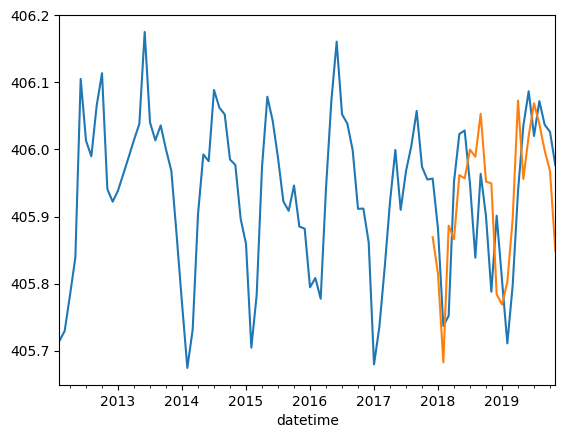

In [62]:
import matplotlib.pyplot as plt
dvar["water_level"].plot()
dvar_forecast["water_level"].plot()